## Objective  
Build a reusable ML pipeline using Scikit-learn to predict customer churn based on demographic and service usage data.

In [14]:
# ==============================================
# TASK 2: End-to-End ML Pipeline (Telco Churn)
# ==============================================

# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# 2. Load Dataset
# (Download Telco Customer Churn dataset from Kaggle or public source)
df = pd.read_csv("Telco-Customer-Churn.csv")

In [16]:
# Preview dataset
print(df.head())
print(df.info())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [17]:
# 3. Data Preprocessing
# Target variable
y = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)  # Convert Yes/No → 1/0
X = df.drop("Churn", axis=1)

# Identify numerical & categorical columns
num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns

print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)

Numerical columns: Index(['SeniorCitizen', 'tenure', 'MonthlyCharges'], dtype='object')
Categorical columns: Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges'],
      dtype='object')


In [18]:
# 4. Preprocessing Pipelines
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])


In [19]:
# Combine preprocessing for both column types
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ])


In [20]:
# 5. Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [21]:
# 6. Build Pipelines for Models
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

In [22]:
# 7. Train & Evaluate Logistic Regression
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



In [23]:
# 8. Hyperparameter Tuning (Random Forest)
param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [5, 10, None]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring="f1", verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 200}


In [24]:
# 9. Evaluate Random Forest
y_pred_rf = best_model.predict(X_test)
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.65      0.49      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.79      1409



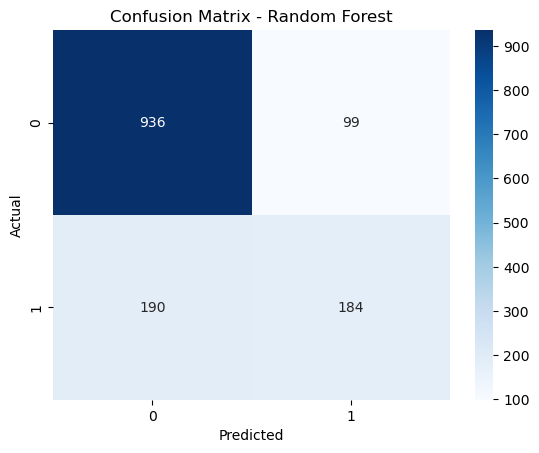

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [26]:
# 10. Export Best Model Pipeline
joblib.dump(best_model, "churn_pipeline.pkl")
print("Pipeline saved as churn_pipeline.pkl")

Pipeline saved as churn_pipeline.pkl
